# Preamble

In [3]:
import Pkg;
Pkg.add("ForwardDiff"); 
Pkg.add("Plots"); 
Pkg.add("LaTeXStrings"); 
Pkg.add("DifferentialEquations"); 
Pkg.add("Roots"); 
Pkg.add("QuadGK"); 
Pkg.add("HCubature");
Pkg.add("MultiQuad");
Pkg.add("Interpolations");
Pkg.add("Dierckx");
Pkg.add("SpecialFunctions");
Pkg.add("LinearAlgebra");
Pkg.add("DelimitedFiles");

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
   Installed Roots ─ v2.2.8
    Updating `~/.julia/environments/v1.11/Project.toml`
  [f2b01f46] + Roots v2.2.8
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [f2b01f46] + Roots v2.2.8
Precompiling project...
   1744.8 ms  ✓ Roots
    898.5 ms  ✓ Roots → RootsChainRulesCoreExt
    787.5

In [1]:
using ForwardDiff, Plots, LaTeXStrings, DifferentialEquations, Roots, QuadGK, HCubature, MultiQuad, Interpolations, Dierckx, SpecialFunctions, LinearAlgebra, DelimitedFiles
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3);

In [3]:
Mpl = 2.435e18; # reduced Planck mass in GeV
c = 299792458; # speed of light in m/s
KinGeV = (1.160e4)^-1 * 10^-9; # Kelvin in GeV
Mpcinm = 3.086e16 * 10^6; # Mpc in m
GeVinminv = 10^9/(1.973e-7); # GeV in m^-1
GeVinMpcinv = GeVinminv * Mpcinm; # GeV in Mpc^-1
MpcinvinHz = c/Mpcinm; # Mpc^inv in Hz
yrins = 365.2422 * 24 * 60 * 60; # yr in s

Or0h2 = 4.2e-5; # current radiation density parameter * h^2
Hubblh = 0.674; # normalised Hubble parameter h

T0 = 2.725*KinGeV; # current temperature
grho0 = 3.383; # current grho
gs0 = 3.931; # current gs

In [5]:
Threads.nthreads() # No. of threads for parallelisation

8

## background load

In [7]:
bgdata = readdlm("data/bg.csv", ',');

etaList = bgdata[:,1];
anormList = bgdata[:,2];
calHList = bgdata[:,3];
EoSwList = bgdata[:,4];
cs2List = bgdata[:,5];
grhoList = bgdata[:,6];
gsList = bgdata[:,7];

In [9]:
# interpolation

lnetaList = log10.(etaList);
etai = etaList[1];
etaf = etaList[length(etaList)];

alneta = Spline1D(lnetaList, anormList, k=3);
aint(eta) = alneta(log10(eta))
calHlneta = Spline1D(lnetaList, calHList, k=3);
calHint(eta) = calHlneta(log10(eta));
EoSwlneta = Spline1D(lnetaList, EoSwList, k=3);
EoSwint(eta) = EoSwlneta(log10(eta))
cs2lneta = Spline1D(lnetaList, cs2List, k=3);
cs2int(eta) = cs2lneta(log10(eta));
grholneta = Spline1D(lnetaList, grhoList, k=3);
grhoint(eta) = grholneta(log10(eta))
gslneta = Spline1D(lnetaList, gsList, k=3);
gsint(eta) = gslneta(log10(eta));

In [11]:
(etai, etaf)

(5.780118551592031e-14, 9.89372279833361)

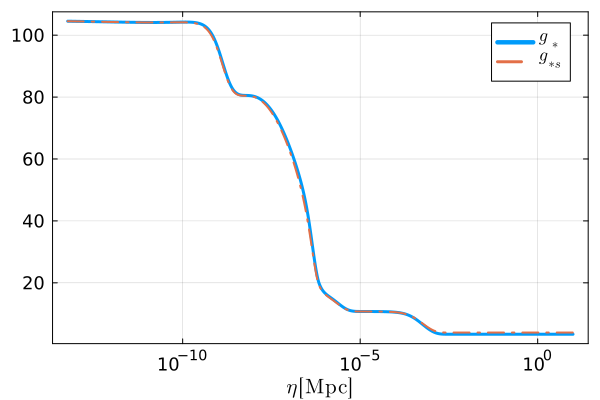

In [13]:
plot(grhoint, etaList, xscale=:log10, label=L"$g_*$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", legend=true)
plot!(gsint, etaList, label=L"$g_{*s}$", linewidth=:2, linestyle=:auto)

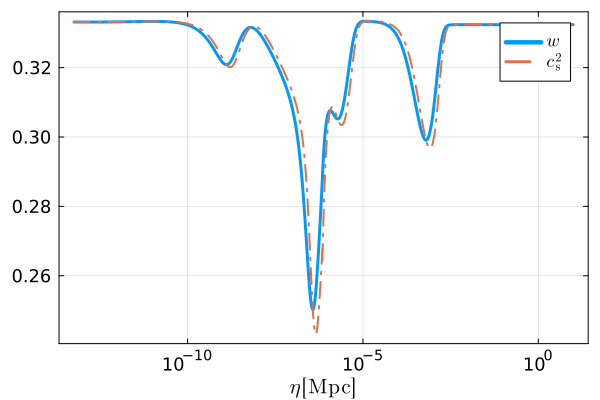

In [14]:
plot(EoSwint, etaList, xscale=:log10, label=L"$w$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", legend=true)
plot!(cs2int, etaList, label=L"$c_\mathrm{s}^2$", linewidth=:2, linestyle=:auto)

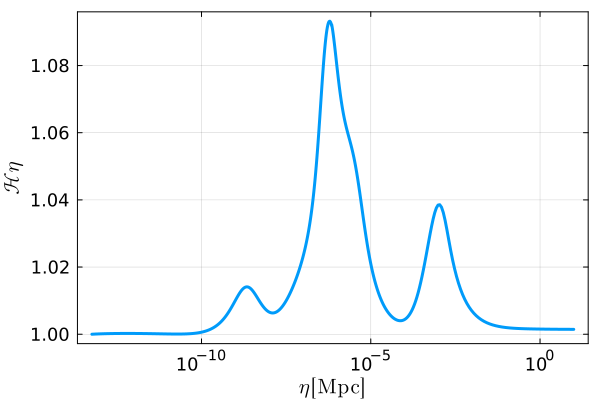

In [15]:
plot(etaList, map(x -> x*calHint(x), etaList), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}\eta$")

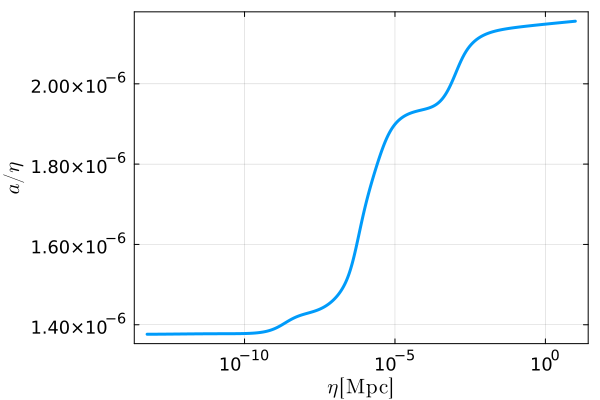

In [16]:
plot(etaList, map(x -> aint(x)/x, etaList), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$a/\eta$")

# kGW = 1e4, ks = 1e9

In [21]:
kGW = 1e4;
ks = 1e9;

xi = 1e-2; # initial time in terms of x = k\eta 
xf = 1e6; # final time in terms of x = k\eta

PhiRD1(x) = 9/x^2 * (sin(x/sqrt(3))/(x/sqrt(3)) - cos(x/sqrt(3))); # Phi in exact RD
PhiRD2(x) = 9/x^2 * (cos(x/sqrt(3))/(x/sqrt(3)) + sin(x/sqrt(3))); # the other independent sol.
PhipRD1(x) = ForwardDiff.derivative(PhiRD1,x); # their x derivatives
PhipRD2(x) = ForwardDiff.derivative(PhiRD2,x);
MPhi(x) = [PhiRD1(x) PhiRD2(x); PhipRD1(x) PhipRD2(x)];

wsk2(k,eta) = cs2int(eta) + 3*calHint(eta)^2/k^2*(cs2int(eta) - EoSwint(eta)); # effective freq. squared

function scalarEoM(du,u,p,x) # u[1] = Phi, u[2] = dPhidx, p = ks
    eta = x/p
    du[1] = u[2]
    du[2] = - 3*calHint(eta)/p*(1 + cs2int(eta))*u[2] - wsk2(p,eta)*u[1]
end;

ui = [Float64(PhiRD1(big(xi))), Float64(PhipRD1(big(xi)))];
xspan = (xi,xf);

scalarprob = ODEProblem(scalarEoM,ui,xspan,ks);

In [23]:
@time scalarsol = solve(scalarprob,Tsit5(),reltol=1e-10,abstol=1e-10);

 16.687471 seconds (145.23 M allocations: 2.705 GiB, 9.62% gc time, 4.97% compilation time)


In [25]:
# solve Phi and Pi = Phi' on a general b.g. up to xc.
# for x > xc, RD sol. will be used where Phic and Pic are adopted as the initial condition at xc
PhiRDc(x,xc,Phic,Pic) = (MPhi(x)*inv(MPhi(xc))*[Phic,Pic])[1]; 
PhipRDc(x,xc,Phic,Pic) = (MPhi(x)*inv(MPhi(xc))*[Phic,Pic])[2];

# interpolation
# RD sol. in the superH limit for x < xi
# num. sol. for xi <= x <= xf
# RD sol. extrapolating the num. sol. for x > xf
function Phiint(x,xc) 
    if x < xi
        return PhiRD1(x)
    elseif x > xc
        return PhiRDc(x,xc,scalarsol(xc)[1],scalarsol(xc)[2])
    else 
        return scalarsol(x)[1]
    end
end;

function Piint(x,xc) 
    if x < xi
        return PhipRD1(x)
    elseif x > xc
        return PhipRDc(x,xc,scalarsol(xc)[1],scalarsol(xc)[2])
    else 
        return scalarsol(x)[2]
    end
end;

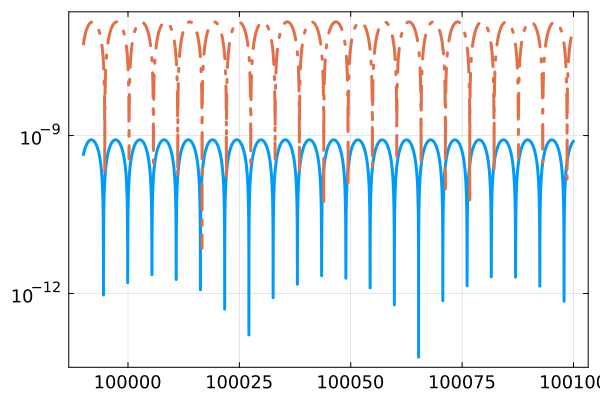

In [57]:
xcs = 1e4
xlist = [x for x in 10xcs-10:0.01:10xcs+100];

plot(xlist, x -> abs(Phiint(x,xcs)), yscale=:log10)
plot!(xlist, x -> abs(scalarsol(x)[1]), linestyle=:auto)

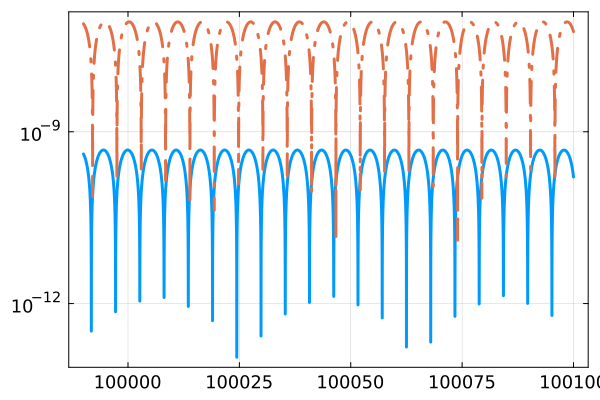

In [59]:
plot(xlist, x -> abs(Piint(x,xcs)), yscale=:log10)
plot!(xlist, x -> abs(scalarsol(x)[2]), linestyle=:auto)